In [18]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

df = pd.read_csv(path + '/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [20]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)

    text = text.lower()

    text = re.sub(r'[^a-z]', ' ', text)

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

df['clean_message'] = df['message'].apply(preprocess_text)

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['clean_message'])

y = df['label']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()

cross_val_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Cross-validation scores: [0.9764574  0.98318386 0.96632997 0.97755331 0.97194164]
Mean cross-validation score: 0.9750932342860594
Accuracy: 0.9766816143497757
Precision: 0.9920634920634921
Recall: 0.8333333333333334
F1 Score: 0.9057971014492754

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.99      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



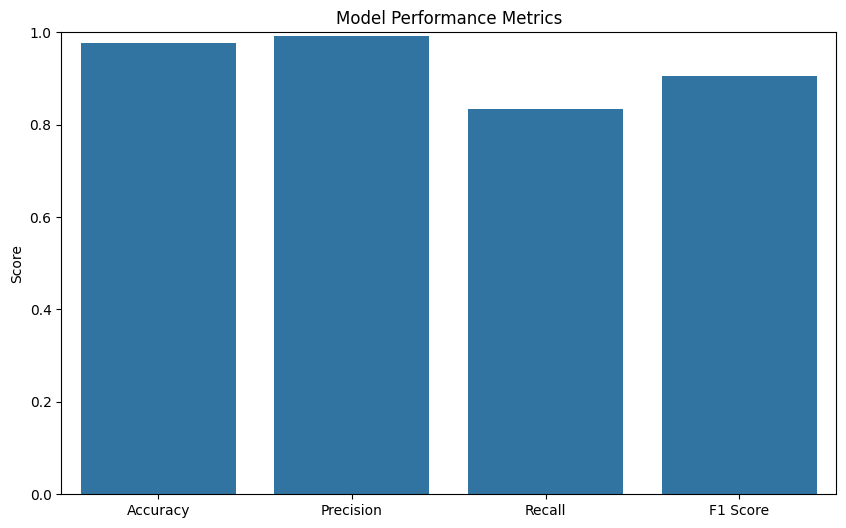

In [22]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=scores)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

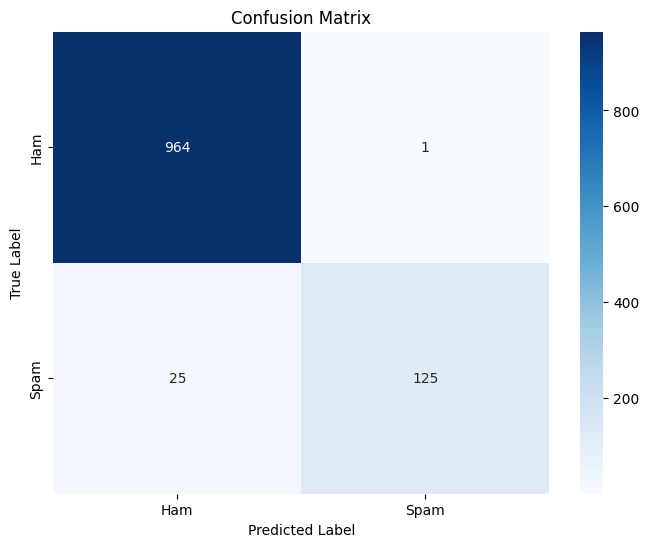

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

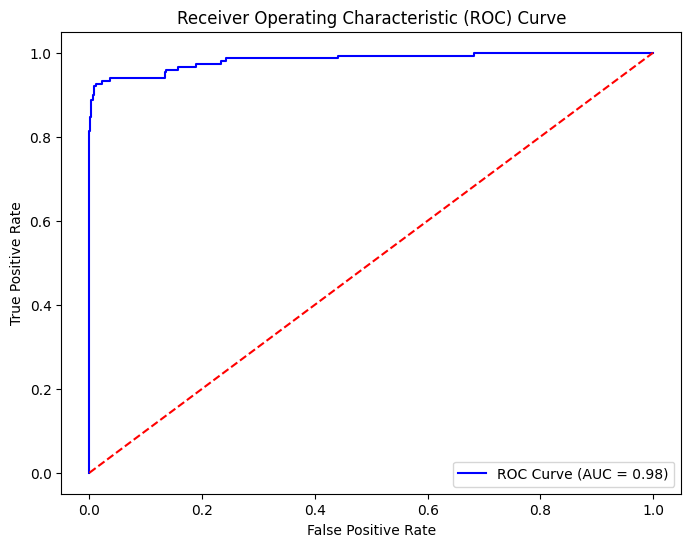

In [24]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

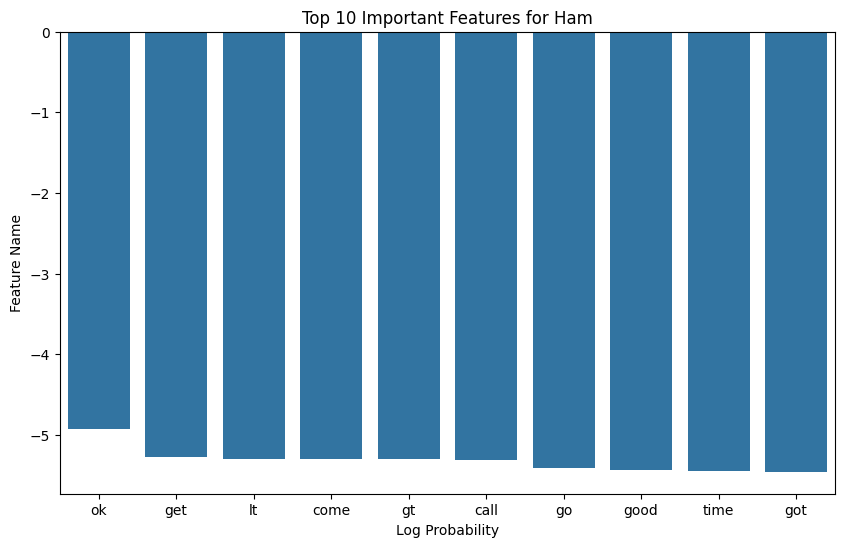

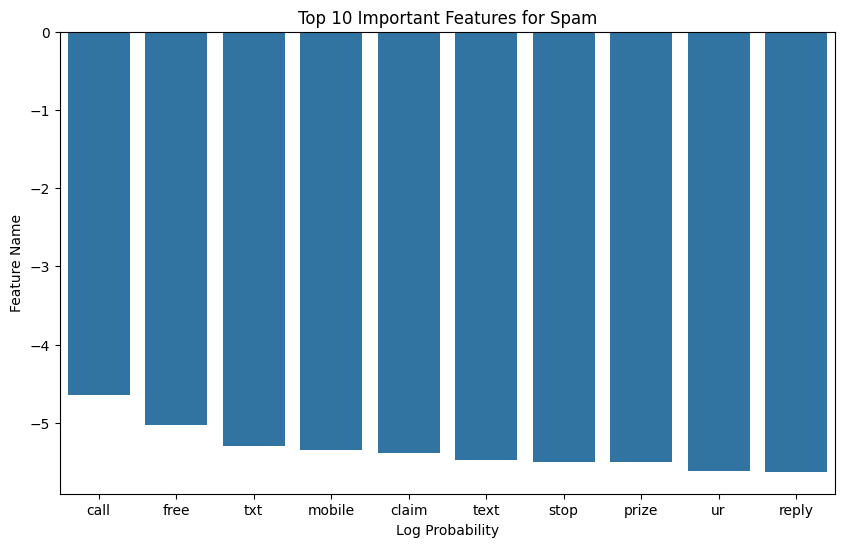

In [25]:
feature_names = tfidf.get_feature_names_out()

log_probabilities = model.feature_log_prob_

top_n = 10
ham_features = sorted(zip(log_probabilities[0], feature_names), reverse=True)[:top_n]
spam_features = sorted(zip(log_probabilities[1], feature_names), reverse=True)[:top_n]

ham_feature_names, ham_feature_values = zip(*ham_features)
spam_feature_names, spam_feature_values = zip(*spam_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=ham_feature_values, y=ham_feature_names)
plt.title('Top 10 Important Features for Ham')
plt.xlabel('Log Probability')
plt.ylabel('Feature Name')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=spam_feature_values, y=spam_feature_names)
plt.title('Top 10 Important Features for Spam')
plt.xlabel('Log Probability')
plt.ylabel('Feature Name')
plt.show()

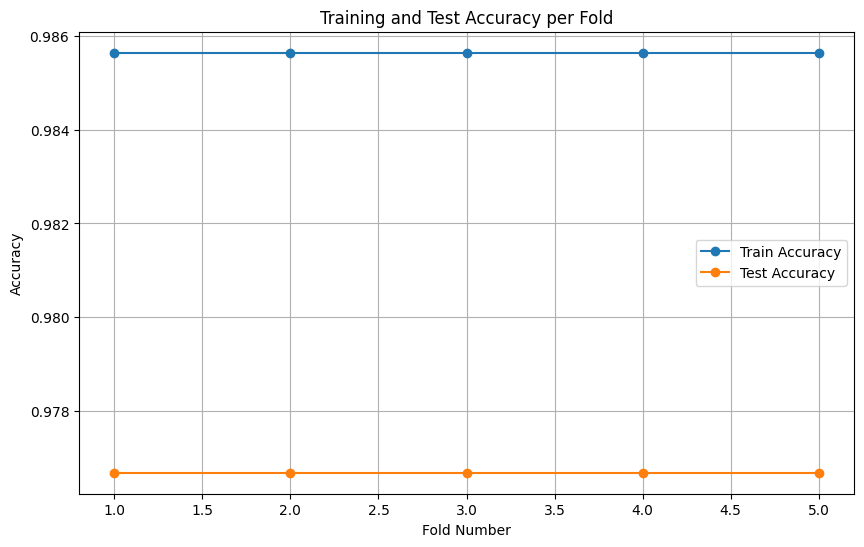

In [26]:
train_scores = []
test_scores = []

for i in range(5):
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), train_scores, label='Train Accuracy', marker='o')
plt.plot(range(1, 6), test_scores, label='Test Accuracy', marker='o')
plt.title('Training and Test Accuracy per Fold')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()